In [3]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import torch
import torch.nn as nn


import os
import sys

from tqdm import tqdm 

In [ ]:
# dataset = Cityscapes("./cityscapes_data/", split="train", mode ='fine', target_type='semantic')
# tqdm(os.listdir(train_filepath), 
#                        desc = 'Building Training Dataset: ')





In [22]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
print (Label)

<class '__main__.Label'>


In [23]:
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [24]:
#prepare id to color mapping
id2color = { label.id : np.asarray(label.color) for label in labels }
print(id2color)
label_colours  = id2color


{0: array([0, 0, 0]), 1: array([0, 0, 0]), 2: array([0, 0, 0]), 3: array([0, 0, 0]), 4: array([0, 0, 0]), 5: array([111,  74,   0]), 6: array([81,  0, 81]), 7: array([128,  64, 128]), 8: array([244,  35, 232]), 9: array([250, 170, 160]), 10: array([230, 150, 140]), 11: array([70, 70, 70]), 12: array([102, 102, 156]), 13: array([190, 153, 153]), 14: array([180, 165, 180]), 15: array([150, 100, 100]), 16: array([150, 120,  90]), 17: array([153, 153, 153]), 18: array([153, 153, 153]), 19: array([250, 170,  30]), 20: array([220, 220,   0]), 21: array([107, 142,  35]), 22: array([152, 251, 152]), 23: array([ 70, 130, 180]), 24: array([220,  20,  60]), 25: array([255,   0,   0]), 26: array([  0,   0, 142]), 27: array([ 0,  0, 70]), 28: array([  0,  60, 100]), 29: array([ 0,  0, 90]), 30: array([  0,   0, 110]), 31: array([  0,  80, 100]), 32: array([  0,   0, 230]), 33: array([119,  11,  32]), 34: array([  0,   0, 142])}


In [25]:
{ label.id for label in labels }
class_map  = dict(zip ( [label.id for label in labels] , range(len(labels)) ))
class_map = {id: label.id for id, label in enumerate(labels)}
# class_map[255] = 0
n_classes = len(class_map)
print(class_map)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34}


In [26]:

datapath = './cityscapes_data/cityscapes_data/'


train_filepath = os.path.join(datapath, 'train')
val_filepath = os.path.join(datapath, 'val')
IMAGE_SIZE = [128, 128]


# Store the images, the masks, and the encoded masks
train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), 
                       desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
#     train_images.append(image)
#     train_masks.append(mask)
#     train_masks_enc.append(find_closest_labels_vectorized(mask, id2color))
   
for val_file in tqdm(os.listdir(val_filepath), 
                     desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
#     val_images.append(image)
#     val_masks.append(mask)
#     val_masks_enc.append(find_closest_labels_vectorized(mask, id2color))
    

FileNotFoundError: [WinError 3] The system cannot find the path specified: './cityscapes_data/cityscapes_data/train'

In [5]:
import mmcls
print(mmcls.__version__)
import mmcv


from mmcls.apis import init_model

0.24.1


In [6]:
import mmdet3d
print (mmdet3d.__version__)

1.0.0rc5


In [ ]:
from argparse import ArgumentParser

from mmdet3d.apis import (inference_multi_modality_detector, init_model,
                          show_result_meshlab)
                          

In [ ]:
parser = ArgumentParser()
parser.add_argument('pcd', help='Point cloud file')
parser.add_argument('image', help='image file')

parser.add_argument('ann', help='ann file')
parser.add_argument('config', help='Config file')
parser.add_argument('checkpoint', help='Checkpoint file')
parser.add_argument(
    '--device', default='cuda:0', help='Device used for inference')
parser.add_argument(
    '--score-thr', type=float, default=0.0, help='bbox score threshold')
parser.add_argument(
    '--out-dir', type=str, default='demo', help='dir to save results')
parser.add_argument(
    '--show',
    action='store_true',
    help='show online visualization results')
parser.add_argument(
    '--snapshot',
    action='store_true',
    help='whether to save online visualization results')
args = parser.parse_args()

In [ ]:
mmdet3d.

In [ ]:
from typing import Any, Tuple
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

# Prepare kitti dataset

In [43]:
datapathkitti = 'D:/Personal/MTech/Sem3/Project/kittidata'
import torchvision.datasets.kitti as kitti
kittidataset = kitti.Kitti (root=datapathkitti, train= True, 
                     transform = None, 
                     download=True)

Using downloaded and verified file: D:/Personal/MTech/Sem3/Project/kittidata\Kitti\raw\data_object_image_2.zip
Extracting D:/Personal/MTech/Sem3/Project/kittidata\Kitti\raw\data_object_image_2.zip to D:/Personal/MTech/Sem3/Project/kittidata\Kitti\raw


BadZipFile: File is not a zip file

In [30]:
#Prepare data

class FusionDataset(Dataset):
    def __init__(self, path, split, mode, target_type, transform=None):
        self.path= path
        print("data path", os.path.join(path, split))
#         self.len = len(os.listdir(os.path.join(path, split)))
        self.len = 20
        self.split = split
        self.mode = mode
        self.target_type = target_type
        self.transform = transform
        
    def __len__(self):
        return 0
    def __getitem__(self, index:int ): #-> Type[Any , Any]:
        
        if self.transform is not None:
            print('add code here to transform the data')
#             transformed=transform(image=np.array(image), mask=np.array(target))  
#         return torch.tensor(image).float(), torch.tensor(mask).float()
        return image, pointcloud
    
    
fusiondataset = FusionDataset(path=datapath, split="train",mode='fine', target_type='semantic')
img,pointcloud = fusiondataset[20]

data path ./cityscapes_data/cityscapes_data/train


NameError: name 'image' is not defined

In [ ]:
class MyClass_(Dataset):
    def __init__(self, path, split, mode, target_type, transform=None):
        self.path= path
        print("data path", os.path.join(path, split))
        self.len = len(os.listdir(os.path.join(path, split)))
        self.len = 20
        self.split = split
        self.mode = mode
        self.target_type = target_type
        self.transform = transform
    def __len__(self):
        return self.len
        
    def __getitem__(self, index: int ) -> Tuple[Any, Any]:
        imagefile = (os.path.join(self.path, f'{self.split}/{index+1}.jpg'))
        print(imagefile, image.shape, mask.shape)
        image, mask = image_mask_split(imagefile, IMAGE_SIZE)
        
        image = np.array(image) / 255 # crop image section and reformat as normalized np array
        image = image.swapaxes(1, 2).swapaxes(0, 1)
        mask = np.array(mask) # crop mask section and reformat as np array
#         mask = mask.swapaxes(1, 2).swapaxes(0, 1)
    
#         mask = find_closest_labels_vectorized(mask, id2color)
        
        if self.transform is not None:
            transformed=self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']
        return torch.tensor(image).float(), torch.tensor(mask).float()
    
    

data path ./cityscapes_data/cityscapes_data\val
./cityscapes_data/cityscapes_data\val/21.jpg
(3, 128, 128) (128, 128)
torch.Size([3, 128, 128]) torch.Size([128, 128])
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 20. 21. 23. 24. 25.
 26. 27. 28. 29. 30. 31. 33.] 35


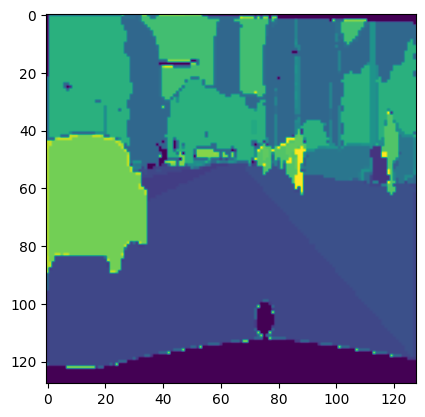

In [31]:
index = 10
path = './cityscapes_data/cityscapes_data'
os.path.join(path, f'{index}.jpg')
# print(os.listdir(os.path.join(path, 'val')))

dataset = MyClass_("./cityscapes_data/cityscapes_data", split= 'val', mode='fine', target_type='semantic',
                  transform=None)
img,seg = dataset[20]

# seg_modified = find_closest_labels_vectorized(seg, id2color)
print(img.shape, seg.shape)
plt.imshow(seg)
# img = np.moveaxis(img, [2], [0])
# print ( np.unique(seg))
# print( np.unique(encode_segmap(seg)))
# print(seg_modified[0])

print( np.unique(seg), n_classes)

In [32]:
print(len(dataset))
for i in range(len(dataset)):
    image, seg = dataset[i]
    print( np.unique(seg), n_classes)

500
./cityscapes_data/cityscapes_data\val/1.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/2.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 21. 23. 24.
 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/3.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 24. 25. 26.
 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/4.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/5.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 15. 16. 17. 19. 20. 21. 23. 24. 25. 26.
 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/6.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 14. 15. 16. 17. 19. 20. 21. 23. 24.

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 24. 25.
 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/53.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 24.
 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/54.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/55.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/56.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 26.
 27. 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/57.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 24. 25.
 26. 27. 28. 29. 3

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 23. 24. 25. 27. 28. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/100.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/101.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 24. 26.
 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/102.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/103.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 32. 33.] 35
./cityscapes_data/cityscapes_data\val/104.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 20. 21. 23. 24. 26. 27.
 28. 30.] 35


(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/149.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 27. 28. 29. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/150.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 20. 21. 22. 23. 26. 27.
 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/151.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 26.
 27. 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/152.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/153.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/197.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/198.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/199.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/200.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 25. 27. 33.] 35
./cityscapes_data/cityscapes_data\val/201.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 11. 12. 14. 15. 16. 17. 21. 23. 26. 27. 28. 29. 30. 31.
 33.] 35
./cityscapes_data/ci

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/244.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 26. 27.
 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/245.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/246.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 24.
 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/247.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 26. 27. 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/248.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 31. 33.] 35


(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 11. 12. 13. 14. 15. 16. 17. 21. 23. 26. 27. 28. 29. 30.] 35
./cityscapes_data/cityscapes_data\val/296.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 16. 20. 21. 23. 26. 27. 28. 29. 30. 31.] 35
./cityscapes_data/cityscapes_data\val/297.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  9. 10. 11. 12. 13. 14. 15. 16. 17. 21. 26. 27. 28. 29.
 30.] 35
./cityscapes_data/cityscapes_data\val/298.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 11. 12. 15. 16. 21. 27. 28. 29. 33.] 35
./cityscapes_data/cityscapes_data\val/299.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 11. 12. 15. 16. 21. 27. 29. 33.] 35
./cityscapes_data/cityscapes_data\val/300.jpg
(3, 128, 128) (128, 128)
[ 0.  6.  7.  8. 11. 15. 16. 21. 27.] 35
./cityscapes_data/cityscapes_data\val/301.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7. 10. 11. 12. 15. 16. 17. 19. 20. 21. 23. 26. 27. 28. 29.
 30.] 35
./cityscapes_data/cityscapes_data\val/302.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6. 

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/350.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/351.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 23. 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/352.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 15. 16. 17. 19. 20. 21. 23. 24. 26. 27.
 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/353.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/354.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22.
 23. 24. 

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/400.jpg
(3, 128, 128) (128, 128)
[ 0.  6.  7.  8. 11. 12. 15. 16. 17. 21. 24. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/401.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 21. 22. 23. 24.
 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/402.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 23. 24. 25. 26.
 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/403.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/404.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 24.
 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/citysca

(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/452.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 24.
 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/453.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23. 24.
 25. 26. 27. 28. 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/454.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 33.] 35
./cityscapes_data/cityscapes_data\val/455.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 11. 12. 13. 15. 16. 17. 20. 21. 23. 24. 26. 27. 28.
 29. 30. 31. 33.] 35
./cityscapes_data/cityscapes_data\val/456.jpg
(3, 128, 128) (128, 128)
[ 0.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 19. 20. 21. 23. 24.
 25. 26. 27. 28. 29. 30. 

In [ ]:


# fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
# # ax[0].imshow(img.permute(1, 2, 0))
# ax[0].imshow(img)
# ax[1].imshow(seg,cmap='gray')



     


In [13]:
from hydrafusion.model import branch, gate, stem, hydranet

ImportError: cannot import name 'load_state_dict_from_url' from 'torchvision.models.resnet' (C:\Users\Jayamohan\miniconda3\envs\fusion\lib\site-packages\torchvision\models\resnet.py)

# Training


In [34]:
from torch.utils.data import DataLoader , Dataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
import segmentation_models_pytorch as smp


In [36]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch


In [ ]:
transform = None
class MyModel(LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer = smp.Unet(
                        encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        classes=n_classes,                      # model output channels (number of classes in your dataset)
           )
        self.lr=1e-3
        self.batch_size=32
        self.numworker=0#multiprocessing.cpu_count()//4
        
        self.criterion= smp.losses.DiceLoss(mode='multiclass')
        self.metrics = torchmetrics.JaccardIndex(task="multiclass",num_classes=n_classes)
        
        self.train_class = MyClass_('./cityscapes_data/cityscapes_data/', split='train', mode='fine',
                     target_type='semantic',transform=transform)
        self.val_class = MyClass_('./cityscapes_data/cityscapes_data/', split='val', mode='fine',
                     target_type='semantic',transform=transform)
        self.test_class = MyClass_('./cityscapes_data/cityscapes_data/', split='val', mode='fine',
                     target_type='semantic',transform=None)
        
       
    def process(self,image,segment):
        out=self(image)
        segment = find_closest_labels_vectorized(mask, id2color)
        loss=self.criterion(out,segment.long())
        iou=self.metrics(out,segment)
        return loss,iou
    
    def forward(self,x):
        return self.layer(x)

    def configure_optimizers(self):
        opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
        return opt

    def train_dataloader(self):
        return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

    def training_step(self,batch,batch_idx):
        image,segment=batch
        loss,iou=self.process(image,segment)
        self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss

    def val_dataloader(self):
        return DataLoader(self.val_class, batch_size=self.batch_size, 
                          shuffle=False,num_workers=self.numworker,pin_memory=True)

    def validation_step(self,batch,batch_idx):
        image,segment=batch
        loss,iou=self.process(image,segment)
        self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
        self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss
    
    def test_dataloader(self):
        return DataLoader(self.test_class, batch_size=self.batch_size, 
                          shuffle=False,num_workers=self.numworker,pin_memory=True)

    def test_step(self,batch,batch_idx):
        image,segment=batch
        loss,iou=self.process(image,segment)
        self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
        self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss

epoch = 1
data_name = 'all'
model_name =  (f'model_{epoch}_data{data_name}')   
model = MyModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='checkpoints',
                                      filename= model_name,
                                      save_last=True)

trainer = Trainer(max_epochs=epoch, 
                  auto_lr_find=False, 
                  auto_scale_batch_size=False,
#                   gpus=-1,
                  precision=16,
                  callbacks=[checkpoint_callback],
                  )


trainer.fit(model)
torch.save(model.state_dict(), f'{model_name}.pth')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: D:\Personal\MTech\Sem3\mobis\lightning_logs

  | Name      | Type                   | Params
-----------------------------------------------------
0 | layer     | Unet                   | 24.4 M
1 | criterion | DiceLoss               | 0     
2 | metrics   | MulticlassJaccardIndex | 0     
-----------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.765    Total estimated model params size (MB)


data path ./cityscapes_data/cityscapes_data/train
data path ./cityscapes_data/cityscapes_data/val
data path ./cityscapes_data/cityscapes_data/val


Sanity Checking: 0it [00:00, ?it/s]

./cityscapes_data/cityscapes_data/val/1.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/2.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/3.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/4.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/5.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/6.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/7.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/8.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/9.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/10.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/11.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/12.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/13.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_data/val/14.jpg
(3, 128, 128) (128, 128)
./cityscapes_data/cityscapes_

In [ ]:
model.validate()

In [ ]:
model.test()


In [ ]:

# saved_model = MyModel()
# saved_model.
# trainer.fit(model)
# torch.save(model.state_dict(), 'model.pth')



     
